In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")
import copy
import os
import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation
import json

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
RESULTS_DIR = os.path.join("../../", "results")
causal_tracing_dir = os.path.join(RESULTS_DIR, "causal_tracing_aie")

hooks = os.listdir(causal_tracing_dir)
relation_files = os.listdir(os.path.join(causal_tracing_dir, hooks[0]))

country_capital_city.json - 4 samples
2024-03-20 22:25:11 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff578526830>
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


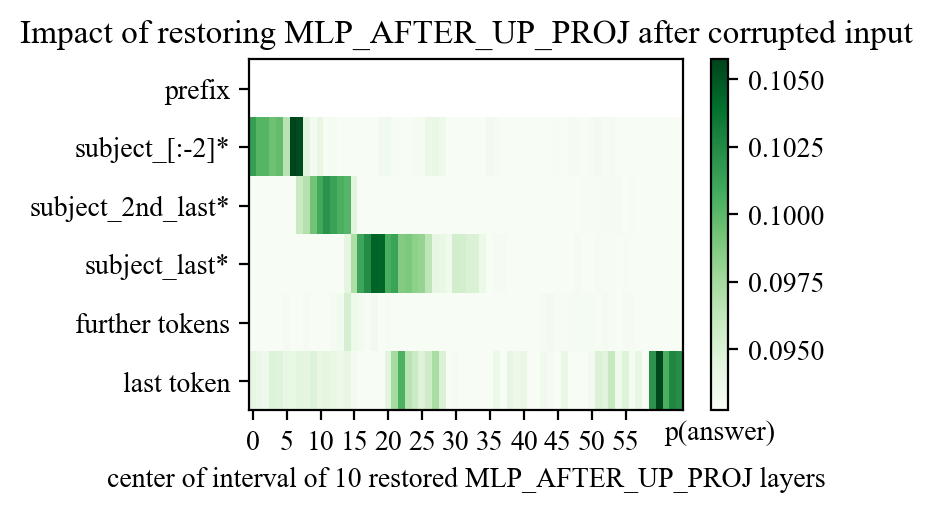

person_plays_pro_sport.json - 150 samples
2024-03-20 22:25:11 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff579b20430>
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


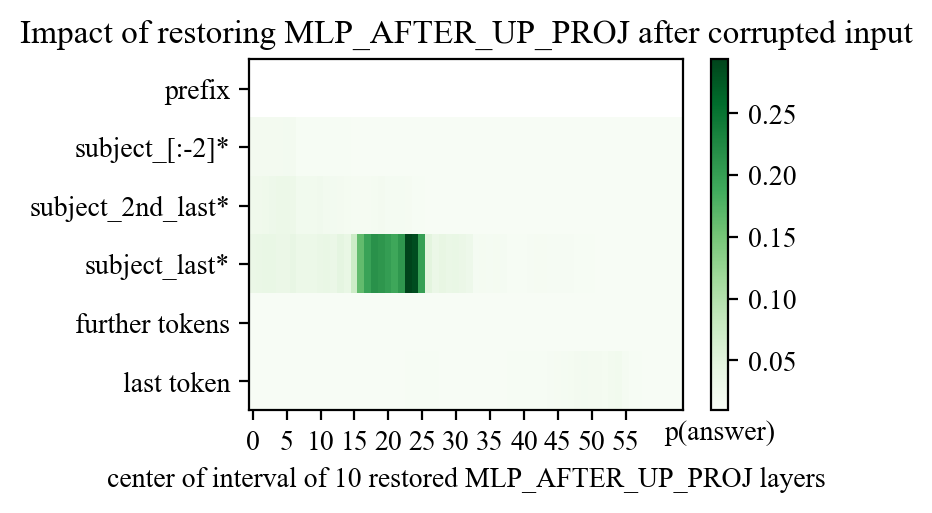

company_hq.json - 16 samples
2024-03-20 22:25:11 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff579050460>
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


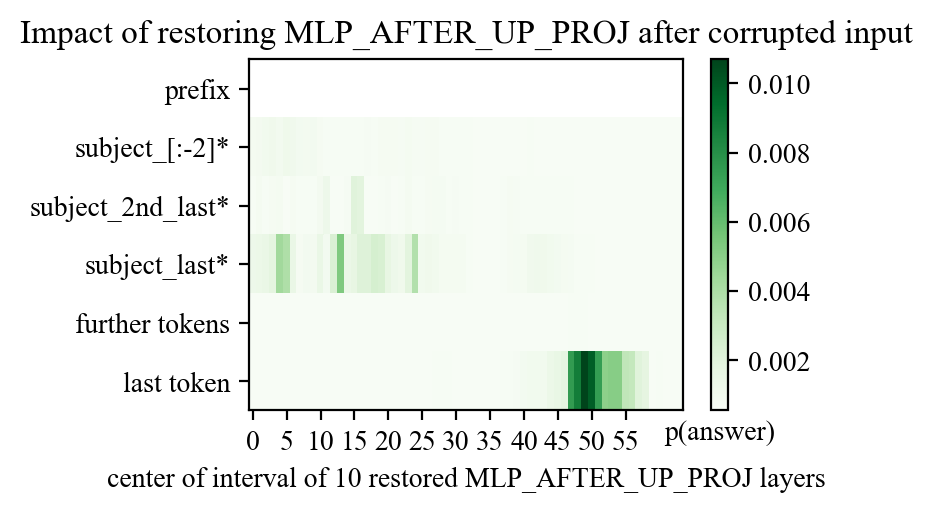

company_ceo.json - 29 samples
2024-03-20 22:25:11 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff5782bb6a0>
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


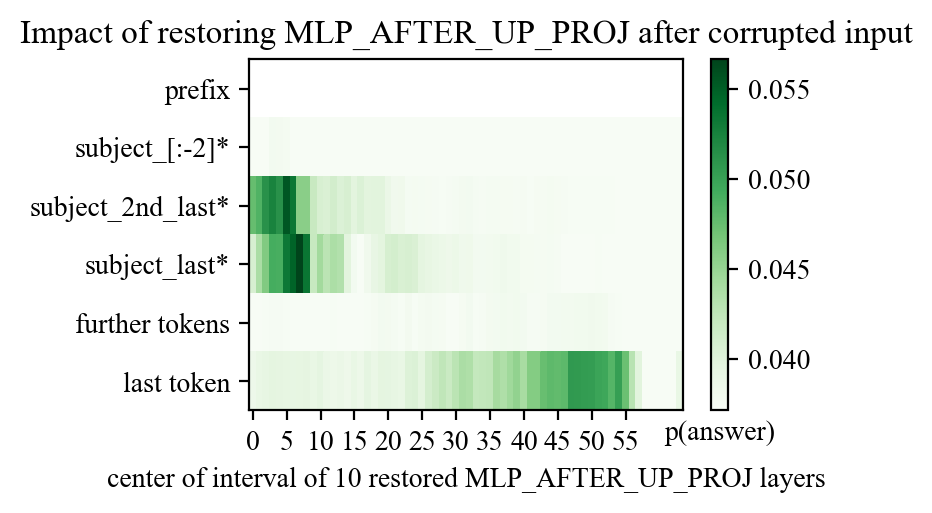

person_occupation.json - 23 samples
2024-03-20 22:25:12 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff57361d060>
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


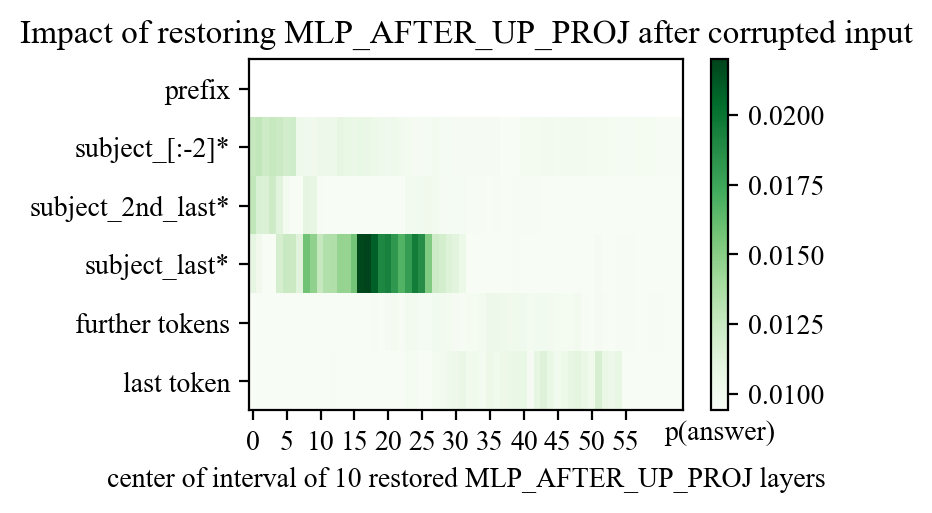

place_in_city.json - 98 samples
2024-03-20 22:25:12 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff5733f3be0>
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


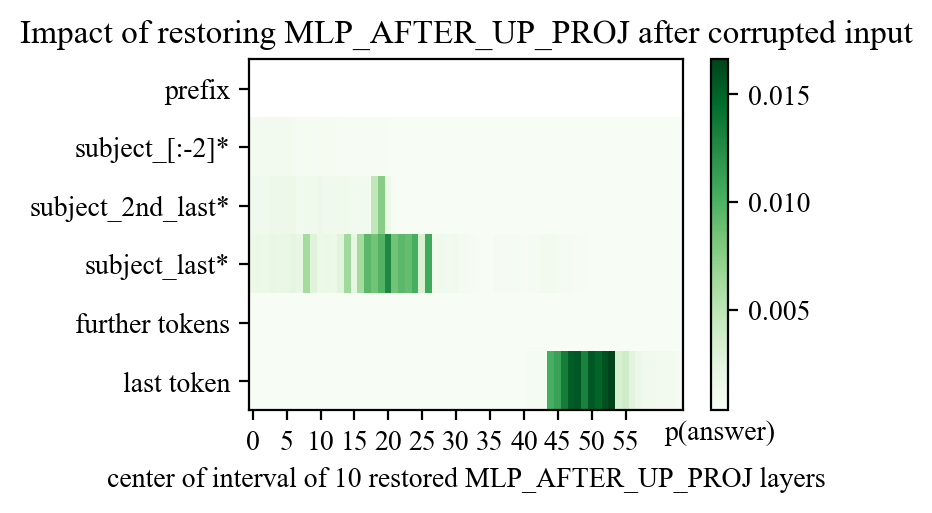

In [5]:
from src.tracing import average_indirect_effects
from src.plotting import plot_trace_heatmap

hook = hooks[0]
aie_all = {}

for relation_file in relation_files:

    with open(os.path.join(causal_tracing_dir, hook, relation_file), "r") as f:
        relation_ie_all = json.load(f)
    
    print(f"{relation_file} - {len(relation_ie_all.keys())} samples")

    for k, v in relation_ie_all.items():
        aie_all[f"{k}_{relation_file}_{hook}"] = v

    relation_aie = average_indirect_effects(relation_ie_all)
    plot_trace_heatmap(relation_aie, modelname="Mamba-2.8b")

320
2024-03-20 22:25:37 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff5732f7d00>
2024-03-20 22:25:37 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:37 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2024-03-20 22:25:37 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-20 22:25:37 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


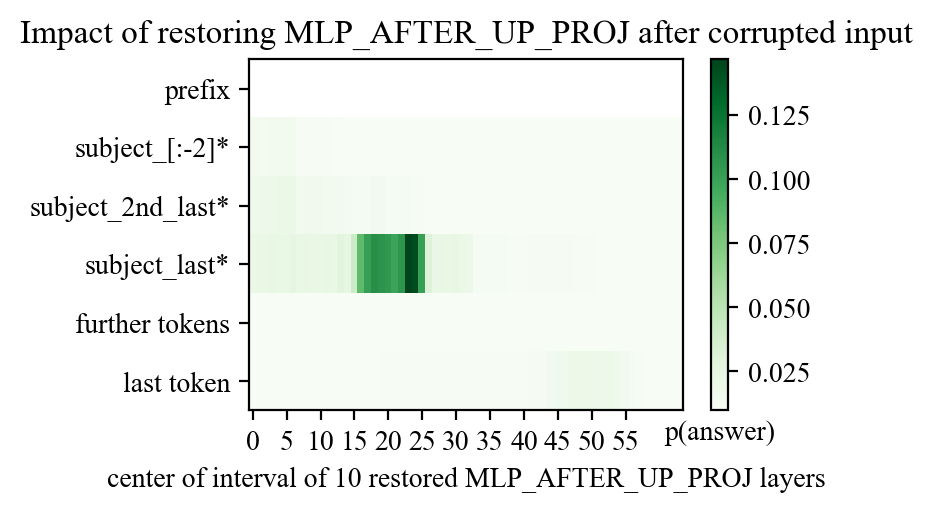

In [6]:
print(len(aie_all.keys()))

aie = average_indirect_effects(aie_all)
plot_trace_heatmap(aie, modelname="Mamba-2.8b")